In [25]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Random
using BlackBoxOptim
include("unicycle_env.jl")
include("controller.jl")
include("problem.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [26]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [72]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5, pos=nothing)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = isnothing(pos) ? [0, 1.5] : pos
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function following(rp::RP, ctrl; fps=10, tf=2, targets=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    infeas=false
    for i in 1:T-1
        xg = [targets[i].center..., norm(targets[i].vel), 0]
        @show
        Xref = get_Xref(x, xg, fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=[targets[i]], safety_index=safety_index)
        u, safe_set = timed_result.value
        dot_x = compute_output(net, [x; u])
        if !(dot_x ∈ safe_set)
            infeas=true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(safety_index, x, targets[i])
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

following (generic function with 1 method)

In [28]:

function following_samples()
    nx = 20
    ny = 20
    nv = 10
    nt = 10
    nov = 1
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-1,stop=1,length=nv)
    θs = range(-π,stop=π,length=nt)
    ov1s = range(-0.,stop=0.,length=nov)
    ov2s = range(-0.,stop=0.,length=nov)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[ov1,ov2],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs, ov1 in ov1s, ov2 in ov2s];
    return samples
end
fol_samples = following_samples();

In [67]:
# function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
#     safe_set = phi_safe_set(safety_index, x, obs, dt)
#     for j in 1:ctrl.num_sample
#         u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
#         dot_x_cand = compute_output(net, [x; u_cand])
#         dot_x_cand ∈ safe_set && (return true)
#     end
#     return false
# end
function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    phi_now = phi(safety_index, x, obs[1])
    phi_next_con = max(0, phi_now - safety_index.gamma * dt)
    for j in 1:ctrl.num_sample
        u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
        x_cand = forward(net, x, u_cand, dt)
        phi_next = phi(safety_index, x_cand, obs[1])
        if phi_next < phi_next_con
            return true
        end
    end
    return false
end
function eval_following_index(coes)
    Random.seed!(1)
    margin, gamma, phi_power, dot_phi_coe = coes
    d_max = 2
    d_min = 1
    index = FollowingIndex(d_min, d_max, margin, gamma, phi_power, dot_phi_coe)
    
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in fol_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        evc = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += evc
        if !evc
            @show sample
        end
    end
    @show coes, Float64(length(fol_samples)-valid)
    return Float64(length(fol_samples)-valid)
#     success_rate, phi0_vio_rate, infeas_rate  = following_stat(100, index)
#     infeas_cnt = length(fol_samples)-valid
#     @show coes, infeas_cnt, success_rate, phi0_vio_rate, infeas_rate
#     return Float64(length(fol_samples)-valid) - success_rate
end

eval_following_index (generic function with 1 method)

In [68]:
eval_following_index([0.1, 5, 2, 1])

sample = ([1.5789473684210527, 0.0, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.8421052631578947, 0.0, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.5789473684210527, 0.2631578947368421, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.8421052631578947, 0.2631578947368421, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.3157894736842106, 0.5263157894736842, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.5789473684210527, 0.5263157894736842, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.8421052631578947, 0.5263157894736842, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.3157894736842106, 0.7894736842105263, -1.0, -3.141592653589793], Obstacle[Obstacle([0.0, 0.0], [0.0, 0.0], 0.5)])
sample = ([1.5

LoadError: [91mInterruptException:[39m

In [44]:
include("safe_set.jl")
Random.seed!(2)
bboptimize(eval_following_index; SearchRange = [(1e-3, 0.4), (1., 1.), (0.1,3.), (0.1, 10)], TraceMode=:verbose, MaxFuncEvals=10);

(coes, Float64(length(fol_samples) - valid)) = ([0.14735176856352983, 1.0, 0.7097436488946064, 8.211447541044055], 257.0)
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
(coes, Float64(length(fol_samples) - valid)) = ([0.2567223708739382, 1.0, 2.471818573364249, 3.4082667548491288], 286.0)
(coes, Float64(length(fol_samples) - valid)) = ([0.19624438616893414, 1.0, 0.907058622275934, 6.144103786381613], 290.0)
9.95 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=286.000000000
DE modify state:
(coes, Float64(length(fol_samples) - valid)) = ([0.029718606197880474, 1.0, 2.9805957352396466, 5.5636671310582155], 305.0)
(coes, Float64(length(fol_samples) - valid)) = ([0.0638835737892147, 1.0, 1.537470268183294, 3.7919426907054454], 427.0)
21.66 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fit

┌ Warning: Optimization interrupted, recovering intermediate results...
└ @ BlackBoxOptim /home/wth/.julia/packages/BlackBoxOptim/wxsWF/src/opt_controller.jl:483


In [ ]:
Random.seed!(1)
bboptimize(eval_following_index; SearchRange = [(1e-3, 1), (5., 5.), (3.,3.), (0.1, 10)], TraceMode=:verbose, MaxFuncEvals=10);

LoadError: [91mInterruptException:[39m

In [283]:
Random.seed!(1)
bboptimize(eval_following_index; SearchRange = [(0.01,0.5), (5., 5.), (1.,1.), (0.1, 10)], TraceMode=:verbose, MaxFuncEvals=20);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
2.96 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=2.000000000
DE modify state:
7.18 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=2.000000000
DE modify state:
10.64 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=2.000000000
DE modify state:
14.03 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 1.0000), fitness=2.000000000
DE modify state:
18.45 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 0.0000), fitness=2.000000000
DE modify state:
21.48 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 0.0000), fitness=2.000000000
DE modify state:
25.40 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 1.0000), fitness=2.000000000
DE modify state:
28.51 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 0.

In [45]:
function draw_heat_plot(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    return Float64(length(col_samples)-valid)
end



function find_infeas_states(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    d_min = 1
    d_max = 2
    index = FollowingIndex(d_min, d_max, margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    infeas_states = Dict()
    infeas_map = zeros(size(fol_samples)[1:2])
    for (idx, sample) in pairs(fol_samples)
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        feas = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += feas
        feas && continue
        haskey(infeas_states, (idx[1], idx[2])) || (infeas_states[(idx[1], idx[2])] = [])
        push!(infeas_states[(idx[1], idx[2])], sample)
        infeas_map[idx[1], idx[2]] += 1
    end
    return Float64(length(fol_samples)-valid), infeas_states, infeas_map
end

find_infeas_states (generic function with 1 method)

infeas_cnt1 = 1964.0


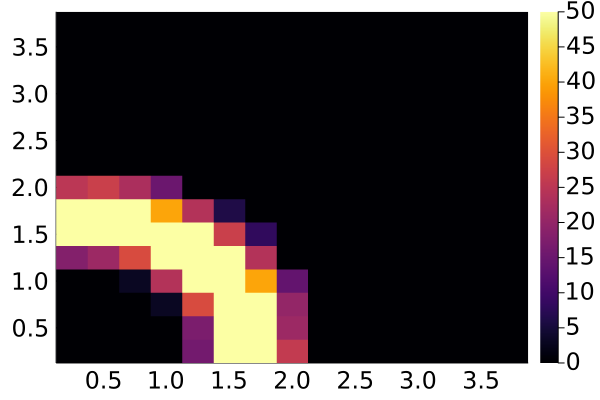

In [69]:
infeas_cnt1, infeas_states1, infeas_map1 = find_infeas_states([0.1, 5, 2, 1]);
@show infeas_cnt1
infeas_map = infeas_map1[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [70]:

function following_stat(num, fi; )
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    fps = 10
    tf = 5
    # x0 = [1.2+rand()*0.6, rand()*0.2-0.1, rand()*2-1, -π+rand()*π/2-π/4]
    
    for j in 1:num

        x0 = [fi.d_min + (fi.d_max - fi.d_min)*0.2 + rand()*(fi.d_max - fi.d_min) * 0.6, 0, rand()*2-1, -π+rand()*π/2-π/4]
        x0 = [fi.d_min + (fi.d_max - fi.d_min)*0.2 + rand()*(fi.d_max - fi.d_min) * 0.6, 0, rand()*2-1, -π+rand()*π/2-π/4]
        xg = [0,0,0,-π]
        obj_cost = [1,1,0.1,0.1]
        rp = RP(net, obj_cost, x0, xg)
        
        obs = Obstacle([0, 0], [0,0], obs_radius)
        targets = [obs for i in 1:Int(tf*fps)]
        
        ctrl = ShootingController(1000)
        Xtrack, Utrack, safe_sets, Xrefs, infeas = following(rp, ctrl, fps=fps, tf=tf, targets=targets, safety_index=fi, verbose=false);
        vio = false
        infeas_cnt += infeas
        for obs in targets
            for x in Xtrack
                if norm(x[1:2]-obs.center) < fi.d_min || norm(x[1:2]-obs.center) > fi.d_max
                    vio = true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
        success += 1 - (vio|infeas)
        if j < 10
            visualize(Xtrack, targets=targets, xlims=[-3,3], ylims=[-1,5], fps=1000)
        end
    end
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

following_stat (generic function with 1 method)

In [55]:
fi = FollowingIndex(1, 2, 0.1, 1e-3, 1, 0)
following_stat(100, fi)

(0.0, 1.0, 0.0)

In [57]:
fi = FollowingIndex(1, 2, 0.2, 1, 1, 1)
following_stat(100, fi)

(1.0, 0.0, 0.0)

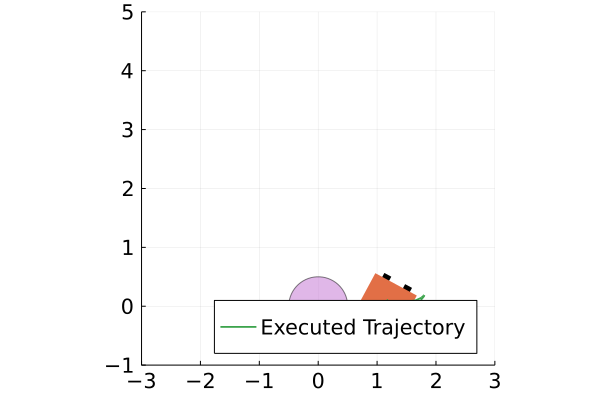

LoadError: [91mInterruptException:[39m

In [71]:
fi = FollowingIndex(1, 2, 0.1, 5, 2, 1)
following_stat(100, fi)

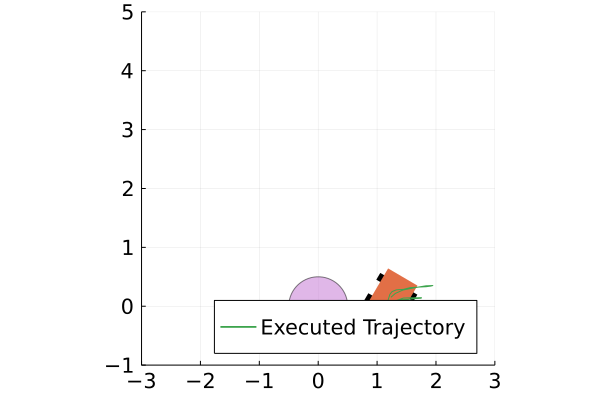

LoadError: [91mInterruptException:[39m

In [73]:
fi = FollowingIndex(1, 2, 0.1, 5, 2, 1)
following_stat(100, fi)

In [58]:
fi = FollowingIndex(1, 2, 0.45, 0.55, 1, 1)
following_stat(100, fi)

(1.0, 0.0, 0.0)

In [16]:
fi = FollowingIndex(1, 2, 0.45, 0.55, 1, 1)
following_stat(100, fi)

(0.82, 0.0, 0.18)

In [307]:
fi = FollowingIndex(1, 2, 0.0511271, 0.0368391, 1.0, 1.19797)
following_stat(100, fi)

(1.0, 0.0, 0.0)

In [35]:
for i = 0.1:0.1:0.3
    for j = 0.4:0.1:0.7
        fi = FollowingIndex(1, 2, i, j, 1, 1)
        res1 = following_stat(100, fi)
        res2 = gt_following_stat(100, fi)
        @show i, j, res1, res2
    end
end

(i, j, res1, res2) = (0.1, 0.4, (0.98, 0.0, 0.02), (1.0, 0.0, 0.0))
(i, j, res1, res2) = (0.1, 0.5, (0.36, 0.02, 0.64), (1.0, 0.0, 0.0))
(i, j, res1, res2) = (0.1, 0.6, (0.53, 0.0, 0.47), (0.81, 0.0, 0.19))
(i, j, res1, res2) = (0.1, 0.7, (0.8, 0.0, 0.2), (1.0, 0.0, 0.0))
(i, j, res1, res2) = (0.2, 0.4, (0.43, 0.0, 0.57), (0.45, 0.0, 0.55))
(i, j, res1, res2) = (0.2, 0.5, (0.33, 0.02, 0.67), (0.48, 0.27, 0.52))
(i, j, res1, res2) = (0.2, 0.6, (0.99, 0.0, 0.01), (0.99, 0.01, 0.01))
(i, j, res1, res2) = (0.2, 0.7, (1.0, 0.0, 0.0), (1.0, 0.0, 0.0))
(i, j, res1, res2) = (0.3, 0.4, (0.06, 0.0, 0.94), (0.05, 0.0, 0.95))
(i, j, res1, res2) = (0.3, 0.5, (0.33, 0.02, 0.67), (0.48, 0.27, 0.52))
(i, j, res1, res2) = (0.3, 0.6, (0.99, 0.0, 0.01), (0.99, 0.01, 0.01))
(i, j, res1, res2) = (0.3, 0.7, (1.0, 0.0, 0.0), (1.0, 0.0, 0.0))


In [33]:
for i = 0.1:0.1:0.1
    for j = 0.6:0.05:0.8
        fi = FollowingIndex(1, 2, i, j, 1, 1)
        res1 = following_stat(100, fi)
        res2 = gt_following_stat(100, fi)
        @show i, j, res1, res2
    end
end

(i, j, res1, res2) = (0.1, 0.6, (0.53, 0.0, 0.47), (0.81, 0.0, 0.19))
(i, j, res1, res2) = (0.1, 0.65, (0.61, 0.0, 0.39), (0.91, 0.0, 0.09))
(i, j, res1, res2) = (0.1, 0.7, (0.8, 0.0, 0.2), (1.0, 0.0, 0.0))
(i, j, res1, res2) = (0.1, 0.75, (0.37, 0.0, 0.63), (0.94, 0.0, 0.06))
(i, j, res1, res2) = (0.1, 0.8, (0.1, 0.0, 0.9), (0.91, 0.0, 0.09))


In [15]:
function gt_following(rp::RP, ctrl; fps=10, tf=2, targets=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    infeas=false
    for i in 1:T-1
        xg = [targets[i].center..., norm(targets[i].vel), 0]
        @show
        Xref = get_Xref(x, xg, fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, [targets[i].center..., norm(targets[i].vel), 0], fps, dt)
#         Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=[targets[i]], safety_index=safety_index)
        u, safe_set = timed_result.value
        if isnothing(u)
            u = i == 1 ? [0.,0.] : U[i-1]
            infeas=true
#             return X[1:i], U[1:i-1], safe_sets, Xrefs, true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(safety_index, x, targets[i])
            @show p
        end
        x = forward(x, u, dt)
        X[i+1] = x
        U[i] = u
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

function gt_following_stat(num, fi; )
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    fps = 10
    tf = 1
    x0 = [1.2+rand()*0.6, rand()*0.2-0.1, rand()*2-1, -π+rand()*π/2-π/4]
    xg = [0,0,0,-π]
    obj_cost = [1,1,0.1,0.1]
    rp = RP(net, obj_cost, x0, xg)
    for j in 1:num
        obs = Obstacle([0, 0], [0,0], obs_radius)
        targets = [obs for i in 1:Int(tf*fps)]
        
        ctrl = ShootingController(1000)
        Xtrack, Utrack, safe_sets, Xrefs, infeas = gt_following(rp, ctrl, fps=fps, tf=tf, targets=targets, safety_index=fi, verbose=false);
        vio = false
        infeas_cnt += infeas
        for obs in targets
            for x in Xtrack
                if norm(x[1:2]-obs.center) < fi.d_min || norm(x[1:2]-obs.center) > fi.d_max
                    vio = true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
        success += 1 - (vio|infeas)
#         if j < 10
#             visualize(Xtrack, targets=targets, xlims=[-3,3], ylims=[-1,5], fps=1000)
#         end
    end
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

gt_following_stat (generic function with 1 method)

In [16]:
fi = FollowingIndex(1, 2, 0.1, 1e-3, 1, 0)
gt_following_stat(100, fi)

(0.0, 1.0, 1.0)

In [34]:
fi = FollowingIndex(1, 2, 0.1, 0.6, 1, 1)
gt_following_stat(100, fi)

(0.81, 0.0, 0.19)

In [18]:
fi = FollowingIndex(1, 2, 0.0511271, 0.0368391, 1.0, 1.19797)
gt_following_stat(100, fi)

(1.0, 0.0, 0.0)